In [2]:
from glob import glob
from os.path import join, basename
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from filtering import freq_filt
from correlate import norm_correlate
from pathlib import Path
from tqdm import tqdm
import pickle
from itertools import combinations

In [12]:
with open('/Users/zachkeskinen/Documents/infrasound/data/hor-1.pkl' , 'rb') as f:
    hor = pickle.load(f)
with open('/Users/zachkeskinen/Documents/infrasound/data/vert-1.pkl' , 'rb') as f:
    vert = pickle.load(f)
vert = vert.drop(['c2-a3m-upper'], axis = 1)
corr_df = pd.concat([hor['c1-hor1'], vert[['c3-a3m-upper', 'c1-be4-lower']]], axis = 1)
corr_df_na = corr_df.dropna()

In [73]:
from scipy.signal import correlate, correlation_lags
from filtering import freq_filt

def norm_correlate(arr1, arr2, filt = True):
    if filt:
        arr1 = freq_filt(arr1, 1,'highpass')
        arr2 = freq_filt(arr2, 1,'highpass')
    c = correlate((arr1 - np.mean(arr1))/np.std(arr1), (arr2 - np.mean(arr2))/np.std(arr2), 'full') / min(len(arr1), len(arr2))
    l = correlation_lags(arr1.size, arr2.size,)
    return c, l
sps = 200

In [249]:
t = np.array_split(corr_df_na, int(len(corr_df_na)/(5*sps)))
thresh = 0.5
subs = []
for sub in tqdm(t):
    d = {}
    for i, sens in enumerate(freq_filt(sub.values.T, 1, 'highpass')):
        d[i] = sens #???
    cs = []
    for i1,i2 in combinations(d.values(), 2):
        c, l = norm_correlate(i1, i2)
        cs.append(np.max(c))
    mean_corr = np.mean(cs)
    if mean_corr > thresh:
        print(sub.index[0])
        print('-'.center(10, '-'))
        subs.append(sub)

 44%|████▍     | 26212/59587 [01:55<02:25, 228.66it/s]

2022-01-24 20:02:06.950000+00:00
----------
2022-01-24 20:02:16.950000+00:00
----------


 46%|████▋     | 27626/59587 [02:01<02:23, 223.50it/s]

2022-01-24 23:59:56.950000+00:00
----------


 50%|████▉     | 29772/59587 [02:10<02:02, 243.21it/s]

2022-01-25 05:54:56.950000+00:00
----------


 60%|█████▉    | 35708/59587 [02:35<01:39, 241.16it/s]

2022-01-25 22:24:06.950000+00:00
----------


 60%|██████    | 35931/59587 [02:36<01:39, 237.87it/s]

2022-01-25 23:01:06.950000+00:00
----------
2022-01-25 23:02:16.950000+00:00
----------
2022-01-25 23:02:26.950000+00:00
----------
2022-01-25 23:02:36.950000+00:00
----------
2022-01-25 23:02:56.950000+00:00
----------


 61%|██████    | 36227/59587 [02:37<01:38, 237.23it/s]

2022-01-25 23:54:16.950000+00:00
----------
2022-01-25 23:56:36.950000+00:00
----------
2022-01-25 23:56:46.950000+00:00
----------
2022-01-25 23:56:56.950000+00:00
----------


 62%|██████▏   | 36721/59587 [02:39<01:34, 240.74it/s]

2022-01-26 01:12:46.950000+00:00
----------


 65%|██████▌   | 38899/59587 [02:48<01:27, 237.33it/s]

2022-01-26 07:16:06.950000+00:00
----------


100%|██████████| 59587/59587 [04:14<00:00, 233.69it/s]


In [275]:
dt = pd.to_datetime('2022-01-26 07:16:06.950000+00:00')
td1 =1.75
start = dt+pd.Timedelta(f'{td1} seconds')
print(start)
td2 = 4.25
end = dt+pd.Timedelta(f'{td2} seconds')
fc = 1

dtend = start
corr = pd.Series(dtype=float)
while dtend < end:
    sub = corr_df_na.loc[dtend: dtend + pd.Timedelta('0.25 seconds')]
    corr.loc[dtend] = np.max(norm_correlate(sub['c1-hor1'].values, sub['c1-be4-lower'].values)[0])
    dtend = dtend + pd.Timedelta('0.25 seconds')
corr.plot()
plt.show()

sub = corr_df_na.loc[dt+pd.Timedelta(f'{td1} seconds'):dt+pd.Timedelta(f'{td2} seconds')]
# for col in sub:
#     sub.loc[:, col] = sub.loc[:,col]/ sub.loc[:,col].std()
#     sub.loc[:, col] = sub.loc[:,col] - sub.loc[:,col].mean()
sub.loc[:, sub.columns] = freq_filt(sub.values.T, fc,'highpass').T
sub.plot()
plt.show()
# dt = pd.to_datetime('2022-01-21 19:14:53.810000+00:00')
sub = vert.loc[dt+pd.Timedelta(f'{td1} seconds'):dt+pd.Timedelta(f'{td2} seconds')]
# for col in sub:
#     sub.loc[:, col] = sub.loc[:,col]/ sub.loc[:,col].std()
#     sub.loc[:, col] = sub.loc[:,col] - sub.loc[:,col].mean()
sub.loc[:, sub.columns] = freq_filt(sub.values.T, fc,'highpass').T
sub.plot()
plt.show()

2022-01-26 07:16:08.700000+00:00


ValueError: The length of the input vector x must be greater than padlen, which is 9.

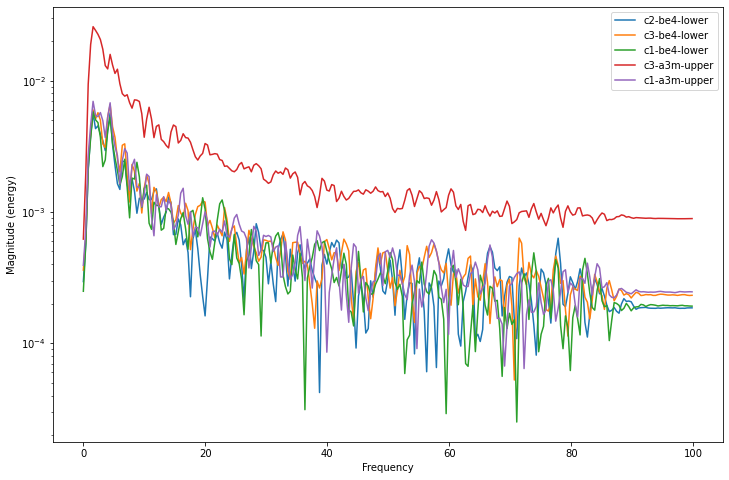

In [274]:
plt.subplots(figsize = (12,8))
for col in sub.columns:
    plt.magnitude_spectrum(sub[col], Fs = 200, label = col)
plt.legend()
# plt.xlim(0, 10)
# plt.xscale('log')
plt.yscale('log')